For each tweet, we have a set of given features.

id: Its an incremental number that is used to identify each tweet

timestamp: The time (in timestamp format) that the tweet was published

retweet_count: the actual number of retweets the tweet receive at the time of the of the crawl(only in training dataset)

user_verified: A boolean field indicating if the user has been verified by Twitter

user_statuses_count: The total number of tweets (statuses) the user has published

user_followers_count: The number of followers the user has

user_friends_count: The number of users that the user is following

user_mentions: The users that are mentioned within the tweet (e.g. "@someuser"). The entries are comma separated (e.g. "someuser,anotheruser"). If nothing is mentioned the field is empty (nan in pandas)

urls: The URLs that are included within the tweet. The entries are comma separated (e.g. "someurl.com,anotherurl.fr") If nothing is mentioned the field is empty (nan in pandas)

hashtags: The hashtags that are included within the tweet. The entries are comma separated (e.g. "hashtag1,hashtag2") If nothing is mentioned the field is empty (nan in pandas)

text: The text of the tweet as posted by the user

In [5]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error

from verstack.stratified_continuous_split import scsplit 

import pickle 

In [25]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], 
                                           stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3)

# Preprocessing

In [2]:
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler

In [73]:
 class FeatureExtractor(object):

    def __init__(self):       
        
        self.scaler = RobustScaler()

        date_column = ['timestamp']
        boolean_column = ['user_verified']
        numerical_columns = ['user_statuses_count', 'user_followers_count',
        'user_friends_count']
        text_column = ['text']

        def timestamp(X):
            date = pd.to_datetime(X['timestamp'], unit='ms')
            return np.c_[date.dt.minute, date.dt.hour, date.dt.day, date.dt.month]

        timestamp_transformer = FunctionTransformer(timestamp, validate=False)


        def boolean(X):
            X['user_verified_int'] = X['user_verified'].astype(int)
            return X['user_verified_int'][:,np.newaxis]

        boolean_transformer = FunctionTransformer(boolean, validate=False)

        def text(X):
            vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
            X_text = vectorizer.fit_transform(X['text'])
            length = X['text'].str.len().to_numpy()
            return np.c_[X_text.toarray(), length[:,np.newaxis]]
        
        text_transformer = FunctionTransformer(text, validate=False)


        self.preprocessor = ColumnTransformer(
            transformers=[
                ('scaling', self.scaler, numerical_columns),
                ('date', make_pipeline(timestamp_transformer, self.scaler), date_column),
                ('bool', boolean_transformer, boolean_column),    
                ('text', text_transformer, text_column),  
                ])
        pass
    
    def fit(self, X_df):
        self.preprocessor.fit(X_df)
        pass
    
    def transform(self, X_df):
        X_encoded = X_df
        X_array = self.preprocessor.transform(X_encoded)
        return X_array
        

In [74]:
Feature_Extractor = FeatureExtractor()
Feature_Extractor.fit(X_train)
X = Feature_Extractor.transform(X_train)

In [69]:
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_text = vectorizer.fit_transform(X_train['text'])

# SVR

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

In [13]:
X_reduced.shape

(466043, 10)

In [ ]:
reg = SVR(kernel='rbf')
reg.fit(X_reduced, y_train)

In [ ]:
Feature_Extractor.fit(X_test)
X_test_transformed = Feature_Extractor.transform(X_test)
y_pred = reg.predict(X_test_transformed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

# Random Forest

In [ ]:
reg = RandomForestRegressor(random_state=0, n_estimators=20, max_depth=4, criterion='mae', verbose=1)
reg.fit(X, y_train)

In [ ]:
Feature_Extractor.fit(X_test)
X_test_processed = Feature_Extractor.transform(X_test)

In [9]:
Feature_Extractor.fit(X_test)
X_test_transformed = Feature_Extractor.transform(X_test)
y_pred = reg.predict(X_test_processed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 262.073255732733


# Gradient Boosting Regressor

In [90]:
# tf–idf = term frequency–inverse document frequency
#vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
#X_train = vectorizer.fit_transform(X_train['text'])
#X_test = vectorizer.transform(X_test['text'])

In [76]:
# Now we can train our model. Here we chose a Gradient Boosting Regressor and we set our loss function 
params = {'verbose': 1,
          'n_estimators': 50,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'lad'}  #least absolute deviation
reg = GradientBoostingRegressor(**params)
# We fit our model using the training data
reg.fit(X, y_train)

      Iter       Train Loss   Remaining Time 
         1         148.1110            6.63m
         2         147.9526            6.60m
         3         147.6208            6.33m
         4         147.4313            6.28m
         5         147.0816            6.89m
         6         146.8686            6.89m
         7         146.7351            6.82m
         8         146.6887            6.49m
         9         146.5284            6.19m
        10         146.2687            5.93m
        20         144.5861            4.09m
        30         143.4859            2.85m
        40         143.0158            1.41m
        50         142.7686            0.00s


GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_split=5,
                          n_estimators=50, verbose=1)

In [ ]:
# And then we predict the values for our testing set
#y_pred = reg.predict(X_test)
#print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

In [28]:
Feature_Extractor.fit(X_test)
X_test_processed = Feature_Extractor.transform(X_test)

In [31]:
y_pred = reg.predict(X_test_processed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 143.79363117025466


In [26]:
# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg, file)

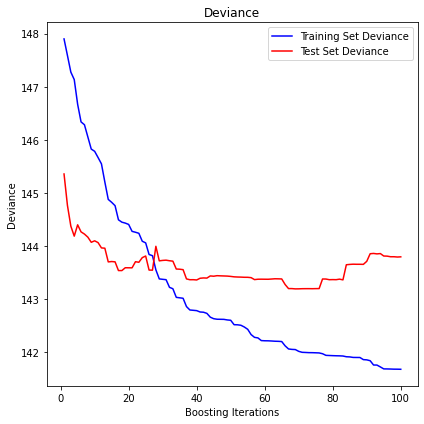

In [33]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test_processed)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Prediction for the evaluating dataset

In [19]:
# Load from file
with open("pickle_model.pkl", 'rb') as file:
    model = pickle.load(file)

In [8]:
# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

In [16]:
Feature_Extractor.fit(eval_data)
X_val = Feature_Extractor.transform(eval_data)

In [18]:
X_val.shape

(285334, 108)

In [21]:
# Predict the number of retweets for the evaluation dataset
y_pred = model.predict(X_val)

In [22]:
# Dump the results into a file that follows the required Kaggle template
with open("gbr_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['id'].iloc[index]) , str(int(prediction))])